In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
import re
from collections import Counter
import os
import re

train_csv_path = ".\\data\\ground_truth\\train\\annotations.csv"
train_img_dir = ".\\data\\images\\train"

Bounding Box Coordinates: x=0, y=0, w=426, h=153


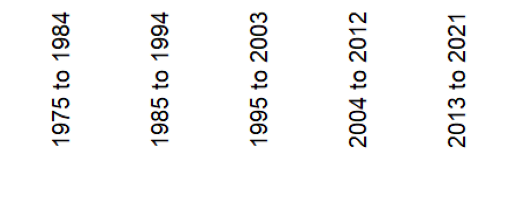

Bounding Box Coordinates: x=0, y=0, w=426, h=710


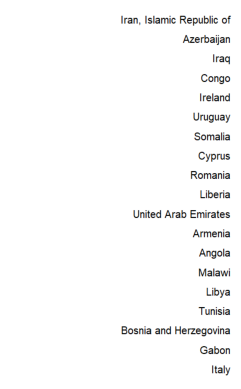

Bounding Box Coordinates: x=0, y=0, w=299, h=710


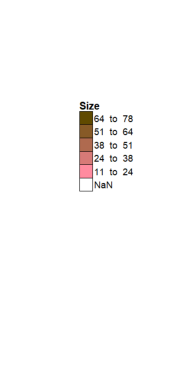

Bounding Box Coordinates: x=0, y=0, w=1200, h=137


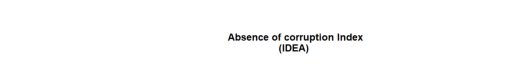

In [11]:
class RegionDetection:
  '''
  Identifies the region of interest for the extraction of text
  '''

  def __init__(self, image_path, image_name):
    self.image_path = image_path
    self.image_name = image_name
    self.image = cv2.imread(self.image_path)
    self.contours = self.find_contours()
    self.image_np = np.array(self.image)
    self.largest_contour = self.detect_grid()

  def find_contours(self):

    gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

  def detect_grid(self):

    largest_contour = max(self.contours, key=cv2.contourArea)
    return largest_contour
  
  def detect_color_legend(self):
  
    # Calculate areas for all contours
    contours_with_areas = [(contour, cv2.contourArea(contour)) for contour in self.contours]
    
    # Sort contours by area in descending order
    sorted_contours = sorted(contours_with_areas, key=lambda x: x[1], reverse=True)
    
    # Return the second largest contour if it exists
    if len(sorted_contours) > 1:
      second_largest_contour = sorted_contours[1][0]
      return second_largest_contour

  # Displays the region of interest
  def crop_detected_roi(self, roi):

    # Convert the ROI to grayscale
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Calculate the bounding box coordinates
    x, y, w, h = cv2.boundingRect(gray_roi)
    
    # Debug: Print the coordinates
    print(f"Bounding Box Coordinates: x={x}, y={y}, w={w}, h={h}")
    
    # Draw the bounding box on the original image
    cv2.rectangle(self.image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Debug: Display the grayscale ROI
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


  def detect_title_roi(self):
    
    if self.largest_contour is not None:
      x, y, w, h = cv2.boundingRect(self.largest_contour)
      top = max(0, y - h)
      title_roi = self.image_np[top:y, :]

      return title_roi
  
  def detect_yaxis_roi(self):

    if self.largest_contour is not None:
      x, y, w, h = cv2.boundingRect(self.largest_contour)
      left = max(0, x - w)
      yaxis_roi = self.image_np[y:y + h, left:x]

      return yaxis_roi

  def detect_xaxis_roi(self):

    if self.largest_contour is not None:
      x, y, w, h = cv2.boundingRect(self.largest_contour)
      bottom = min(self.image_np.shape[0], y + 2 * h)
      xaxis_roi = self.image_np[y + h:bottom, x:x + w]

      return xaxis_roi

  def detect_legend_roi(self):
    
    x, y, w, h = cv2.boundingRect(self.largest_contour)
    right = max(self.image.shape[1], x + 2 * w)
    legend_roi = self.image[y:y + h, x + w:right]

    return legend_roi


df = pd.read_csv(train_csv_path)


for _, row in df.iloc[:1].iterrows():
  image_name = row.iloc[0]
  image_path = os.path.join(train_img_dir, image_name)
  roi = RegionDetection(image_path, image_name)

  xaxis_roi = roi.detect_xaxis_roi()
  roi.crop_detected_roi(xaxis_roi)

  yaxis_roi = roi.detect_yaxis_roi()
  roi.crop_detected_roi(yaxis_roi)

  legend_roi = roi.detect_legend_roi()
  roi.crop_detected_roi(legend_roi)

  title_roi = roi.detect_title_roi()
  roi.crop_detected_roi(title_roi)


In [12]:
class TextExtraction(RegionDetection):
  '''
  Extracts the text in the given region of interest.
  '''

  def __init__(self, image_path, image_name):
    super().__init__(image_path, image_name)
    self.image_path = image_path
    self.img = cv2.imread(image_path)
    self.title_roi = self.detect_title_roi()
    self.yaxis_roi = self.detect_yaxis_roi()
    self.xaxis_roi = self.detect_xaxis_roi()
    self.legend_roi = self.detect_legend_roi()

    if self.img is None:
      raise FileNotFoundError(f"Image not found or unable to read: {image_path}")

  def preprocess_image(self):

    gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
    return binary

  def extract_title(self):

    title_text = pytesseract.image_to_string(self.title_roi)
    return title_text

  def extract_yaxis_labels(self):

    yaxis_text = pytesseract.image_to_string(self.yaxis_roi)
    return yaxis_text

  def extract_xaxis_labels(self):
    
    cropped_image = Image.fromarray(cv2.cvtColor(self.xaxis_roi, cv2.COLOR_BGR2RGB))
    rotated_image = cropped_image.rotate(-90, expand=True)
    
    xaxis_text = pytesseract.image_to_string(rotated_image)
    return xaxis_text

  def remove_legend(self):

    contour = self.detect_color_legend()
    if contour is not None:
      cv2.drawContours(self.image, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
    else:
      print("No legend found in ", self.image_name)

  def extract_legend_values(self):

    self.remove_legend()
    preprocessed_image = self.preprocess_image()
    x, y, w, h = cv2.boundingRect(self.largest_contour)
    roi = preprocessed_image[y:y+h, x+w:]

    roi_image = Image.fromarray(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    custom_config = r'--psm 6 -c preserve_interword_spaces=1 --oem 3'
    legend_text = pytesseract.image_to_string(roi_image, config=custom_config)

    return legend_text
  
df = pd.read_csv(train_csv_path)

for _, row in df.iloc[:1].iterrows():
  image_name = row.iloc[0]
  image_path = os.path.join(train_img_dir, image_name)
  extracted_text = TextExtraction(image_path, image_name)

  print("Extracted X-Axis Labels")
  print(extracted_text.extract_xaxis_labels())

  print("\nExtracted Y-Axis Labels")
  print(extracted_text.extract_yaxis_labels())

  print("\nExtracted Title")
  print(extracted_text.extract_title())

  print("\nExtracted Legend Values")
  print(extracted_text.extract_legend_values())


Extracted X-Axis Labels
1975 to 1984

1985 to 1994

1995 to 2003

2004 to 2012

2013 to 2021


Extracted Y-Axis Labels
Iran, Islamic Republic of
Azerbaijan

Iraq

Congo

Ireland

Uruguay

Somalia

Cyprus

Romania

Liberia

United Arab Emirates
Armenia

Angola

Malawi

Libya

Tunisia

Bosnia and Herzegovina
Gabon

Italy


Extracted Title
Absence of corruption Index
(IDEA)


Extracted Legend Values
Size
64 to 78
51 to 64
38 to 51
24 to 38
11 to 24
NaN



In [13]:
class TextFormatter:
    
  def __init__(self, text):
    self.text = text

  def clean_title(self):
    title = self.text.extract_title()
    title = title.replace('\n', ' ')
    return title
  
  def clean_yaxis_label(self):
    
    yaxis_labels = self.text.extract_yaxis_labels()
    array_yaxis = yaxis_labels.splitlines()
    array_yaxis = [label for label in array_yaxis if label]
    
    return array_yaxis

  def clean_xaxis_label(self):

    xaxis_labels = self.text.extract_xaxis_labels()
    array_xaxis = xaxis_labels.splitlines()
    array_xaxis = [label for label in array_xaxis if label]
    
    return array_xaxis

  def clean_legend_values(self):

    legend_values = self.text.extract_legend_values()
    array_legend_values = legend_values.splitlines()
    array_legend_values = [value for value in array_legend_values if value]

    return array_legend_values
  
df = pd.read_csv(train_csv_path)

for _, row in df.iloc[:1].iterrows():
  image_name = row.iloc[0]
  image_path = os.path.join(train_img_dir, image_name)
  extracted_text = TextExtraction(image_path, image_name)
  formatted_text = TextFormatter(extracted_text)

  print("Formatted X-Axis Values")
  print(formatted_text.clean_xaxis_label())

  print("\nFormatted Y-Axis Values")
  print(formatted_text.clean_yaxis_label())

  print("\nFormatted Title")
  print(formatted_text.clean_title())

  print("\nFormatted Legend Values")
  print(formatted_text.clean_legend_values())
  

Formatted X-Axis Values
['1975 to 1984', '1985 to 1994', '1995 to 2003', '2004 to 2012', '2013 to 2021']

Formatted Y-Axis Values
['Iran, Islamic Republic of', 'Azerbaijan', 'Iraq', 'Congo', 'Ireland', 'Uruguay', 'Somalia', 'Cyprus', 'Romania', 'Liberia', 'United Arab Emirates', 'Armenia', 'Angola', 'Malawi', 'Libya', 'Tunisia', 'Bosnia and Herzegovina', 'Gabon', 'Italy']

Formatted Title
Absence of corruption Index (IDEA) 

Formatted Legend Values
['Size', '64 to 78', '51 to 64', '38 to 51', '24 to 38', '11 to 24', 'NaN']


In [19]:
class ColorExtractor(RegionDetection):
  '''
  Extracts color in the given image contour
  '''

  def __init__(self, image_path, image_name):
    super().__init__(image_path, image_name)
    self.image_path = image_path
    self.color_legend = self.detect_color_legend()

  def extract_legend_color(self):
    image = Image.open(self.image_path).convert('RGB')
    image_array = np.array(image)

    x, y, width, height = cv2.boundingRect(self.color_legend)
    legend_roi = image_array[y:y+height, x:x+width]

    # iterates over the pixels of the given image
    flattened_colors = [color for row in legend_roi for color in row if not np.array_equal(color, [0, 0, 0])]

    unique_colors = []
    seen = set()

    for color in flattened_colors:
      color_tuple = tuple(color)

      if color_tuple not in seen:
        seen.add(color_tuple)
        unique_colors.append(color)

    return unique_colors
  
  def extract_grid_color(self):
    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(self.largest_contour)

    # Crop the region of interest from the original image using the bounding box
    cropped_image = self.image[y:y+h, x:x+w]

    num_regions_y = self.yaxis_len
    num_regions_x = self.xaxis_len

    # Calculate the new dimensions that are divisible by the specified number of regions
    new_height = (h // num_regions_y) * num_regions_y
    new_width = (w // num_regions_x) * num_regions_x

    # Resize the cropped image to the new dimensions while maintaining the aspect ratio
    resized_image = cv2.resize(cropped_image, (new_width, new_height))
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Calculate the width and height of each smaller region
    region_height = new_height // num_regions_y
    region_width = new_width // num_regions_x

    dominant_colors = []

    # Extract and display each smaller region
    for i in range(num_regions_y):
      for j in range(num_regions_x):
          
        start_y = i * region_height
        end_y = start_y + region_height
        start_x = j * region_width
        end_x = start_x + region_width
        smaller_region = resized_image_rgb[start_y:end_y, start_x:end_x]

        # Convert the smaller region to a 2D array of pixels
        pixels = smaller_region.reshape((-1, 3))
        pixels = np.float32(pixels)

        # Define criteria and apply K-means clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        k = 1
        _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Get the dominant color
        dominant_color = centers[0].astype(int).tolist()
        dominant_colors.append(dominant_color)

    return dominant_colors
  
df = pd.read_csv(train_csv_path)

for _, row in df.iloc[:1].iterrows():
  image_name = row.iloc[0]
  image_path = os.path.join(train_img_dir, image_name)
  extracted_text = TextExtraction(image_path, image_name)
  cleaned_text = TextFormatter(extracted_text)
  extracted_color = GridProcessor(cleaned_text, image_path, image_name)

  print("Legend Color")
  print(np.array(extracted_color.extract_legend_color()))

  print("\nMatrix Colors")
  print(np.array(extracted_color.extract_grid_color()))

Legend Color
[[ 96  74   0]
 [135  90  39]
 [175 106  79]
 [215 122 119]
 [255 139 159]
 [255 255 255]]

Matrix Colors
[[166 100  75]
 [166 100  75]
 [166 100  75]
 [204 115 113]
 [204 115 113]
 [247 247 247]
 [208 118 115]
 [247 134 154]
 [247 134 154]
 [247 134 154]
 [205 117 114]
 [243 132 151]
 [243 133 152]
 [205 116 114]
 [243 133 152]
 [242 131 150]
 [204 115 113]
 [204 115 113]
 [204 115 113]
 [204 115 113]
 [ 93  71   0]
 [ 93  71   0]
 [ 93  71   0]
 [ 93  71   0]
 [ 93  71   0]
 [128  85  37]
 [ 91  70   0]
 [ 91  70   0]
 [ 91  70   0]
 [ 91  70   0]
 [166 100  75]
 [204 115 113]
 [242 132 151]
 [242 132 151]
 [242 131 150]
 [128  85  37]
 [128  85  37]
 [128  85  37]
 [128  85  37]
 [128  85  37]
 [209 119 116]
 [170 103  77]
 [209 119 116]
 [170 103  77]
 [170 103  77]
 [204 115 113]
 [242 132 151]
 [242 132 151]
 [204 115 113]
 [204 115 113]
 [128  85  37]
 [128  85  37]
 [128  85  37]
 [128  85  37]
 [ 91  70   0]
 [248 248 248]
 [170 103  77]
 [209 118 115]
 [209 118 1

In [16]:
class ColorMapping(ColorExtractor):

  def __init__(self, text, image_path, image_name):
    super().__init__(image_path, image_name)
    self.title = text.clean_title()
    self.yaxis_labels = text.clean_yaxis_label()
    self.xaxis_labels = text.clean_xaxis_label()
    self.legend_values = text.clean_legend_values()
    self.yaxis_len = len(self.yaxis_labels)
    self.xaxis_len = len(self.xaxis_labels)
    self.colors = self.extract_legend_color()
    self.grid_colors = self.extract_grid_color()


  def map_legend_values(self):
    title = self.legend_values[0]
    legend_dict = {"title": title}
    legend_dict.update({tuple(self.colors[i]): self.legend_values[i + 1] for i in range(len(self.colors))})
    return legend_dict

  def color_distance(self, color, legend_color):
    return np.linalg.norm(np.array(color) - np.array(legend_color))

  def find_closest_color(self, color, legend_dict):
    closest_color = None
    min_distance = float('inf')

    for legend_color in legend_dict.keys():
      if legend_color == "title":
        continue
      distance = self.color_distance(color, legend_color)
      if distance < min_distance:
        min_distance = distance
        closest_color = legend_color
    return closest_color

  def map_cell_values(self):
    legend_dict = self.map_legend_values()
    mapped_legend_values = []

    for color in self.grid_colors:

      color_tuple = tuple(color)  # Convert array to tuple for dictionary key
      closest_color = self.find_closest_color(color_tuple, legend_dict)

      if closest_color is not None:
        # mapped_legend_values.append([closest_color, legend_dict[closest_color]])
        mapped_legend_values.append(legend_dict[closest_color])
      else:
        mapped_legend_values.append((color_tuple, None))  # Handle case where no close color is found
    
    return mapped_legend_values

In [17]:
class GridProcessor(ColorMapping):
  
  def __init__(self, text, image_path, image_name):
    super().__init__(text, image_path, image_name)
    self.title = text.clean_title()
    self.yaxis_labels = text.clean_yaxis_label()
    self.xaxis_labels = text.clean_xaxis_label()
    self.legend_values = text.clean_legend_values()
    self.yaxis_len = len(self.yaxis_labels)
    self.xaxis_len = len(self.xaxis_labels)
    self.colors = self.extract_legend_color()
    self.grid_color = self.extract_grid_color()
    self.mapped_grid = self.map_cell_values()

  def create_grid_matrix(self):

    cell_matrix = []
    for j in range(self.yaxis_len):
      for i in range(self.xaxis_len):
        index = j * self.xaxis_len + i  # Calculate the index for 1D list
        mapped_value = self.mapped_grid[index]  # Access the 1D list element
        cell_matrix.append([self.yaxis_labels[j], self.xaxis_labels[i], mapped_value])
    return cell_matrix

  def flatten_list(self, nested_list):
    return [item for sublist in nested_list for item in sublist]
  
df = pd.read_csv(train_csv_path)

for _, row in df.iloc[:1].iterrows():
  image_name = row.iloc[0]
  image_path = os.path.join(train_img_dir, image_name)
  extracted_text = TextExtraction(image_path, image_name)
  cleaned_text = TextFormatter(extracted_text)
  extracted_color = GridProcessor(cleaned_text, image_path, image_name).create_grid_matrix()

  print(np.array(extracted_color))

  

[['Iran, Islamic Republic of' '1975 to 1984' '38 to 51']
 ['Iran, Islamic Republic of' '1985 to 1994' '38 to 51']
 ['Iran, Islamic Republic of' '1995 to 2003' '38 to 51']
 ['Iran, Islamic Republic of' '2004 to 2012' '24 to 38']
 ['Iran, Islamic Republic of' '2013 to 2021' '24 to 38']
 ['Azerbaijan' '1975 to 1984' 'NaN']
 ['Azerbaijan' '1985 to 1994' '24 to 38']
 ['Azerbaijan' '1995 to 2003' '11 to 24']
 ['Azerbaijan' '2004 to 2012' '11 to 24']
 ['Azerbaijan' '2013 to 2021' '11 to 24']
 ['Iraq' '1975 to 1984' '24 to 38']
 ['Iraq' '1985 to 1994' '11 to 24']
 ['Iraq' '1995 to 2003' '11 to 24']
 ['Iraq' '2004 to 2012' '24 to 38']
 ['Iraq' '2013 to 2021' '11 to 24']
 ['Congo' '1975 to 1984' '11 to 24']
 ['Congo' '1985 to 1994' '24 to 38']
 ['Congo' '1995 to 2003' '24 to 38']
 ['Congo' '2004 to 2012' '24 to 38']
 ['Congo' '2013 to 2021' '24 to 38']
 ['Ireland' '1975 to 1984' '64 to 78']
 ['Ireland' '1985 to 1994' '64 to 78']
 ['Ireland' '1995 to 2003' '64 to 78']
 ['Ireland' '2004 to 2012' '

In [20]:
class ColorExtractor(RegionDetection):
  '''
  Extracts color in the given image contour
  '''

  def __init__(self, image_path, image_name):
    super().__init__(image_path, image_name)
    self.image_path = image_path
    self.color_legend = self.detect_color_legend()

  def extract_legend_color(self):
    image = Image.open(self.image_path).convert('RGB')
    image_array = np.array(image)

    x, y, width, height = cv2.boundingRect(self.color_legend)
    legend_roi = image_array[y:y+height, x:x+width]

    # iterates over the pixels of the given image
    flattened_colors = [color for row in legend_roi for color in row if not np.array_equal(color, [0, 0, 0])]

    unique_colors = []
    seen = set()

    for color in flattened_colors:
      color_tuple = tuple(color)

      if color_tuple not in seen:
        seen.add(color_tuple)
        unique_colors.append(color)

    return unique_colors
  
  def extract_grid_color(self):
    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(self.largest_contour)

    # Crop the region of interest from the original image using the bounding box
    cropped_image = self.image[y:y+h, x:x+w]

    num_regions_y = self.yaxis_len
    num_regions_x = self.xaxis_len

    # Calculate the new dimensions that are divisible by the specified number of regions
    new_height = (h // num_regions_y) * num_regions_y
    new_width = (w // num_regions_x) * num_regions_x

    # Resize the cropped image to the new dimensions while maintaining the aspect ratio
    resized_image = cv2.resize(cropped_image, (new_width, new_height))
    resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Calculate the width and height of each smaller region
    region_height = new_height // num_regions_y
    region_width = new_width // num_regions_x

    dominant_colors = []

    # Extract and display each smaller region
    for i in range(num_regions_y):
      for j in range(num_regions_x):
          
        start_y = i * region_height
        end_y = start_y + region_height
        start_x = j * region_width
        end_x = start_x + region_width
        smaller_region = resized_image_rgb[start_y:end_y, start_x:end_x]

        # Convert the smaller region to a 2D array of pixels
        pixels = smaller_region.reshape((-1, 3))
        pixels = np.float32(pixels)

        # Define criteria and apply K-means clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        k = 1
        _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Get the dominant color
        dominant_color = centers[0].astype(int).tolist()
        dominant_colors.append(dominant_color)

    return dominant_colors
  
df = pd.read_csv(train_csv_path)

for _, row in df.iloc[:1].iterrows():
  image_name = row.iloc[0]
  image_path = os.path.join(train_img_dir, image_name)
  extracted_text = TextExtraction(image_path, image_name)
  cleaned_text = TextFormatter(extracted_text)
  extracted_color = GridProcessor(cleaned_text, image_path, image_name)

  print("Legend Color")
  print(np.array(extracted_color.extract_legend_color()))

  print("\nMatrix Colors")
  print(extracted_color.extract_grid_color())

Legend Color
[[ 96  74   0]
 [135  90  39]
 [175 106  79]
 [215 122 119]
 [255 139 159]
 [255 255 255]]

Matrix Colors
[[166, 100, 75], [166, 100, 75], [166, 100, 75], [204, 115, 113], [204, 115, 113], [247, 247, 247], [208, 118, 115], [247, 134, 154], [247, 134, 154], [247, 134, 154], [205, 117, 114], [243, 132, 151], [243, 133, 152], [205, 116, 114], [243, 133, 152], [242, 131, 150], [204, 115, 113], [204, 115, 113], [204, 115, 113], [204, 115, 113], [93, 71, 0], [93, 71, 0], [93, 71, 0], [93, 71, 0], [93, 71, 0], [128, 85, 37], [91, 70, 0], [91, 70, 0], [91, 70, 0], [91, 70, 0], [166, 100, 75], [204, 115, 113], [242, 132, 151], [242, 132, 151], [242, 131, 150], [128, 85, 37], [128, 85, 37], [128, 85, 37], [128, 85, 37], [128, 85, 37], [209, 119, 116], [170, 103, 77], [209, 119, 116], [170, 103, 77], [170, 103, 77], [204, 115, 113], [242, 132, 151], [242, 132, 151], [204, 115, 113], [204, 115, 113], [128, 85, 37], [128, 85, 37], [128, 85, 37], [128, 85, 37], [91, 70, 0], [248, 248, 2

In [22]:
class DataTransformation:
  '''
  Converts the annotation and extracted texts from images into tokens or sequence
  '''
  def __init__(self, csv_dir, img_dir):
    self.csv_dir = csv_dir
    self.img_dir = img_dir
    spacy.prefer_gpu()
    self.spacy_eng = spacy.load("en_core_web_sm")


  def read_csv(self, file_path):
    df = pd.read_csv(file_path)
    return df
  
  @property
  def preprocess_data(self):
    all_img_data, all_annotation_data = self.collect_data
    return all_img_data, all_annotation_data

  @property
  def collect_data(self): # Returns tokenized img data, and annotation data
    img_data = []
    annotation_data = []
    df = self.read_csv(self.csv_dir)

    for _, row in df.iloc[:2].iterrows():
      image_name = row.iloc[0]
      image_path = os.path.join(self.img_dir, image_name)

      values = TextExtraction(image_path, image_name)
      clean_values = TextFormatter(values)
      
      matrix_values = GridProcessor(clean_values, image_path, image_name).create_grid_matrix()
      img_data.append(self.tokenize_input(matrix_values))
      
      annotation = self.formatted_text(row.iloc[1])
      tokens = self.spacy_eng.tokenizer(annotation)
      tokenized_annotation = [token.text for token in tokens]
      annotation_data.append(tokenized_annotation)

    return img_data, annotation_data

  def words_to_sequence(self, sentence):

    tokens = self.spacy_eng.tokenizer(sentence.lower())
    return [
        self.word_index[token.text]
        if token.text in self.word_index else self.word_index["<UNK>"]
        for token in tokens
    ]

  def formatted_text(self, text):
    text = re.sub(r'\s*([.,()])\s*', r'\1', text.lower())
    cleaned_caption = re.sub(r'([.,()])', r' \1 ', text)
    cleaned_caption = re.sub(r'\s+', ' ', cleaned_caption).strip()
    return cleaned_caption

  def tokenize_input(self, matrix_values):
    tokenized_matrix = [
        [word.text for item in sub_list for word in self.spacy_eng.tokenizer(str(item))]
        for sub_list in matrix_values
    ]
    return tokenized_matrix

  
  def tokenize_annotation(self, annotation_list):
    annotation_list_tokens = []
    
    for annotation in annotation_list:
      if isinstance(annotation, list):
          annotation = " ".join(annotation)

      tokens = [token.text for token in self.spacy_eng.tokenizer(annotation)]
      annotation_list_tokens.append(tokens)
    
    return annotation_list_tokens

  @property
  def prepare_annotation(self):
    annotation_data = []
    df = self.read_csv(self.csv_dir)

    for _, row in df.iloc[0:2].iterrows():
      annotation = self.formatted_text(row.iloc[1])
      annotation_data.extend(self.spacy_eng.tokenizer(annotation))
    
    return annotation_data

class Vocabulary:
  '''
  Converts the tokenized texts into equivalent sequence in dictionary
  '''
  def __init__(self, data, freq_threshold=2):
    spacy.prefer_gpu()
    self.word_index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
    self.index_word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    self.word_counts = {}
    self.freq_threshold = freq_threshold
    self.annotation_sequence = []
    self.img_text_sequence = []
    self.spacy_eng = spacy.load("en_core_web_sm")
    self.data = data
    self.build_vocab(self.data.prepare_annotation)
    self.pad_data()
    

  def build_vocab(self, captions_list):
    frequency = Counter()
    index = len(self.word_index)

    for token in captions_list:
      frequency[token.text] += 1

      if frequency[token.text] == self.freq_threshold:
        self.word_index[token.text] = index
        self.index_word[index] = f"{token.text}"
        index += 1

    print("\nVocabulary")
    print(self.index_word)
  
  
  # Is used in a loop, input is a single list
  def annotation_to_sequence(self, sentence):
    if isinstance(sentence, list):
        sentence = " ".join(sentence)

    # Convert sentence to a list of tokens
    tokens = sentence.split()

    # Convert tokens to indices
    sequence = [
        self.word_index[token]
        if token in self.word_index else self.word_index["<UNK>"]
        for token in tokens
    ]

    # Append <SOS> at the start and <EOS> at the end
    sequence.insert(0, self.word_index["<SOS>"])
    sequence.append(self.word_index["<EOS>"])

    return sequence
  
  def img_text_to_seq(self, list):
    return [self.annotation_to_sequence(sublist) for sublist in list]

  # Is used in a loop, input is a single list
  def sequence_to_captions(self, sequence):
      return " ".join([self.index_word[index] for index in sequence])
  
  @property
  def convert_to_sequence(self):
    img_text_list, annotation_list = self.data.preprocess_data

    print("\nAll Tokenized Image Data")
    print(img_text_list)

    print("\nAll Tokenized Annotation Data")
    print(annotation_list)

    all_img_text_seq = []
    all_annotation_seq = []

    for img_text in img_text_list:
      img_txt_seq = self.img_text_to_seq(img_text)
      img_data = tf.keras.preprocessing.sequence.pad_sequences(
                  img_txt_seq, maxlen=8, padding="post"
                  )
      all_img_text_seq.append(img_data)

    for annotation in annotation_list:
      annotation_sequence = self.annotation_to_sequence(annotation)
      all_annotation_seq.append(annotation_sequence)
    
    return all_img_text_seq, all_annotation_seq
  
  def pad_data(self):

    img_data, annotation_data = self.convert_to_sequence
    
    annotation_data = tf.keras.preprocessing.sequence.pad_sequences(
        annotation_data, padding="post")

    img_data = tf.keras.preprocessing.sequence.pad_sequences(
                  img_data, maxlen=565, padding="post"
                  )

    print('\nPadded Matrix')
    print(img_data)

    print("\nPadded Annotation data")
    print(annotation_data)

    return img_data, annotation_data
  
transformed_data = DataTransformation(train_csv_path, train_img_dir)
vocab = Vocabulary(transformed_data)


Vocabulary
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'the', 5: ',', 6: 'and', 7: '(', 8: '1975', 9: 'to', 10: ')', 11: '.', 12: 'countries', 13: 'azerbaijan', 14: 'have', 15: 'in', 16: 'index', 17: 'from', 18: '2021', 19: 'such', 20: 'as', 21: 'graph', 22: 'shows', 23: 'of', 24: 'percentage', 25: 'population', 26: 'with', 27: 'access', 28: 'for', 29: '%', 30: 'clean', 31: 'fuels', 32: 'technologies', 33: 'cooking', 34: '2022'}

All Tokenized Image Data
[[['Iran', ',', 'Islamic', 'Republic', 'of', '1975', 'to', '1984', '38', 'to', '51'], ['Iran', ',', 'Islamic', 'Republic', 'of', '1985', 'to', '1994', '38', 'to', '51'], ['Iran', ',', 'Islamic', 'Republic', 'of', '1995', 'to', '2003', '38', 'to', '51'], ['Iran', ',', 'Islamic', 'Republic', 'of', '2004', 'to', '2012', '24', 'to', '38'], ['Iran', ',', 'Islamic', 'Republic', 'of', '2013', 'to', '2021', '24', 'to', '38'], ['Azerbaijan', '1975', 'to', '1984', 'NaN'], ['Azerbaijan', '1985', 'to', '1994', '24', 'to', '38'], ['Azerbai